In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
# evaluate knn on the sonar dataset with k-means ordinal discretization transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
import time

In [2]:
#heart = pd.read_csv('dataset/heart.csv')
heart = pd.read_csv('dataset/heart_failure_clinical_records_dataset.csv')

In [3]:
dataset = heart

In [4]:
dataset.drop_duplicates(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [5]:
dataset

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                       582         0                 20   
1    55.0        0                      7861         0                 38   
2    65.0        0                       146         0                 20   
3    50.0        1                       111         0                 20   
4    65.0        1                       160         1                 20   
..    ...      ...                       ...       ...                ...   
294  62.0        0                        61         1                 38   
295  55.0        0                      1820         0                 38   
296  45.0        0                      2060         1                 60   
297  45.0        0                      2413         0                 38   
298  50.0        0                       196         0                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                      1  265000.00               1.9           130    1   
1                      0  263358.03               1.1           136    1   
2                      0  162000.00               1.3           129    1   
3                      0  210000.00               1.9           137    1   
4                      0  327000.00               2.7           116    0   
..                   ...        ...               ...           ...  ...   
294                    1  155000.00               1.1           143    1   
295                    0  270000.00               1.2           139    0   
296                    0  742000.00               0.8           138    0   
297                    0  140000.00               1.4           140    1   
298                    0  395000.00               1.6           136    1   

     smoking  time  DEATH_EVENT  
0          0     4            1  
1          0     6            1  
2          1     7            1  
3          0     7            1  
4          0     8            1  
..       ...   ...          ...  
294        1   270            0  
295        0   271            0  
296        0   278            0  
297        1   280            0  
298        1   285            0  

[299 rows x 13 columns]

In [6]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

In [7]:
#Standerdize
def standardise(X):
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X) # centering and scaling
    return(scaled_features)

## Train the Adaboost Classifier

In [8]:


def calculate_model(param,X,y):
    
    recall_list_10 = []
    precision_list_10 = []
    specificity_10 = []
    f1_list_10 = []
    accuracy_10 = []
    cpu_10 = []
    roc_10 = []
    

    kfold = KFold(n_splits=10, shuffle=True)
    for i in range(30):
        recall_list = []
        precision_list = []
        specificity = []
        f1_list = []
        accuracy = []
        cpu = []
        roc_list = []
        



        for train_ix, test_ix in kfold.split(X, y):




            X_train , X_test = X[train_ix],X[test_ix]
            y_train , y_test = y[train_ix] , y[test_ix]
            
            t0= time.time()
            if (param == 0):
                model = AdaBoostClassifier()
                
            else:
                model = AdaBoostClassifier(n_estimators=param['clf__n_estimators'], base_estimator=param['clf__base_estimator'],algorithm='SAMME.R',
                                           learning_rate=param['clf__learning_rate'])
                

          

            model.fit(X_train,y_train)
            predictions = model.predict(X_test)
            probs = model.predict_proba(X_test)
            probs = probs[:, 1]
            t1 = time.time() - t0
                        #print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)
            cm = confusion_matrix(y_test,predictions)
            f1_list.append(f1_score(y_test, predictions, average="weighted")*100)

            recall_list.append(recall_score(y_test, predictions, average="weighted")*100)
            precision_list.append(precision_score(y_test, predictions, average="weighted")*100)
            specificity1 = cm[1,1]/(cm[0,1]+cm[1,1])
            if not np.isnan(specificity1):
                specificity.append( (cm[1,1]/(cm[0,1]+cm[1,1]))*100)
            accuracy.append(accuracy_score(y_test, predictions)*100)
            roc_list.append(roc_auc_score(y_test, probs)*100)
            cpu.append(t1)

        precision_list_10.append(sum(precision_list)/10)
        specificity_10.append(sum(specificity)/len(specificity))
        f1_list_10.append(sum(f1_list)/10)
        accuracy_10.append(sum(accuracy)/10)
        recall_list_10.append(sum(recall_list)/10)
        roc_10.append(sum(roc_list)/10)
        cpu_10.append(sum(cpu)/10)



   
    accu = sum(accuracy_10)/30
    pre = sum(precision_list_10)/30
    spec = sum(specificity_10)/30
    rec =  sum(recall_list_10)/30
    f1 =  sum(f1_list_10)/30
    roc = sum(roc_10)/30
    cpu = sum(cpu_10)/30
    return([accu,pre,spec,rec,f1,roc,cpu])



##  Grid serach 

In [9]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
def grid_search():
    clf = Pipeline([('clf', AdaBoostClassifier())])
    
    parameters = {
        'clf__base_estimator': [RandomForestClassifier(),DecisionTreeClassifier(),SVC(probability=True, kernel='linear')],
        'clf__n_estimators': [20, 50, 70, 100],
        'clf__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
        }

    
    gs_clf = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
    gs_clf = gs_clf.fit(X_train,y_train)
    print("Best score accurracy = %.3f%%" %((gs_clf.best_score_)*100.0))
    print("Best parameters are : ")
    print(gs_clf.best_params_)
    return(gs_clf.best_params_)



In [10]:
dict_Adaboost = {}

## First Model without preprocessing 

In [11]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = 0
X=scaled_features
result = calculate_model(param,X,y)
    
dict_Adaboost['Ada'] = result
dict_Adaboost


{'Ada': [80.67164750957856,
  81.50583015186893,
  71.43132793132794,
  80.67164750957856,
  80.46000707089064,
  85.76141210809139,
  0.06631173054377239]}

## Hypertune model using grid search

In [12]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_Adaboost['Hypertuned'] = result
dict_Adaboost

Best score accurracy = 86.558%
Best parameters are : 
{'clf__base_estimator': RandomForestClassifier(), 'clf__learning_rate': 0.2, 'clf__n_estimators': 50}


{'Ada': [80.67164750957856,
  81.50583015186893,
  71.43132793132794,
  80.67164750957856,
  80.46000707089064,
  85.76141210809139,
  0.06631173054377239],
 'Hypertuned': [84.36130268199234,
  85.08023436342773,
  78.68047693047694,
  84.36130268199234,
  84.05123167128627,
  91.02801286899357,
  0.13448200623194376]}

## PCA

In [54]:
from sklearn.decomposition import PCA
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values
pca = PCA(n_components= 6)
pca.fit(scaled_features)
x_pca = pca.transform(scaled_features)

In [55]:
pca.explained_variance_ratio_

array([0.13858049, 0.13159129, 0.10567855, 0.09299485, 0.0858236 ,
       0.08240632])

In [56]:
df_comp = pd.DataFrame(pca.components_,columns=dataset.iloc[:, 0:-1].columns)

<AxesSubplot:>

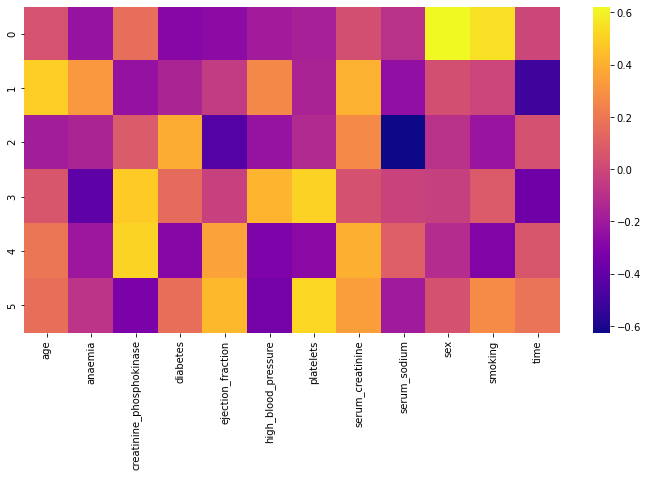

In [57]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

In [58]:
X = x_pca
y = dataset.iloc[:, -1].values
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401)
param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['Pca'] = result


Best score accurracy = 81.957%
Best parameters are : 
{'clf__base_estimator': SVC(kernel='linear', probability=True), 'clf__learning_rate': 0.01, 'clf__n_estimators': 50}


In [59]:
result

[80.19578544061302,
 80.98334103621666,
 72.65114700114698,
 80.19578544061302,
 79.78873023213795,
 85.05841781062763,
 0.817632981141408]

## Chi square 

In [19]:
from sklearn.feature_selection import chi2
X = dataset.iloc[:, 0:-1]
#X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )


f_p_values=chi2(X_train,y_train)
f_p_values
import pandas as pd
p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
p_values

p_values.sort_values(ascending=True)

creatinine_phosphokinase    0.000000e+00
platelets                   0.000000e+00
time                        0.000000e+00
ejection_fraction           4.312121e-17
age                         2.435669e-10
serum_creatinine            4.677796e-04
serum_sodium                3.733849e-01
high_blood_pressure         4.331841e-01
anaemia                     4.695469e-01
diabetes                    9.398230e-01
sex                         9.583940e-01
smoking                     9.705735e-01
dtype: float64

In [20]:
X = dataset[['creatinine_phosphokinase','time','platelets','ejection_fraction','age','serum_creatinine','serum_sodium','high_blood_pressure']].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
X = scaled_features
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )

param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['Chi'] = result


Best score accurracy = 86.975%
Best parameters are : 
{'clf__base_estimator': RandomForestClassifier(), 'clf__learning_rate': 0.01, 'clf__n_estimators': 70}


In [21]:
dict_Adaboost

{'Ada': [80.67164750957856,
  81.50583015186893,
  71.43132793132794,
  80.67164750957856,
  80.46000707089064,
  85.76141210809139,
  0.06631173054377239],
 'Hypertuned': [84.36130268199234,
  85.08023436342773,
  78.68047693047694,
  84.36130268199234,
  84.05123167128627,
  91.02801286899357,
  0.13448200623194376],
 'Pca': [80.15977011494253,
  81.22230473828543,
  76.84986587486586,
  80.15977011494253,
  79.11467778585735,
  85.28630882266944,
  1.7477475786209107],
 'Chi': [83.6888888888889,
  84.55534680438483,
  77.18201243201246,
  83.6888888888889,
  83.44953734883262,
  90.81887041407688,
  0.13260581970214846]}

## discritizer 

In [22]:
categorical_cols = ['anaemia','diabetes','high_blood_pressure','sex','smoking']
numerical_cols = ["age","creatinine_phosphokinase","ejection_fraction","serum_creatinine","platelets","serum_sodium","time"]
target_col = ["DEATH_EVENT"]
from sklearn.preprocessing import KBinsDiscretizer
trans = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
#trans = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
#trans = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
data = trans.fit_transform(dataset[numerical_cols])
# convert the array back to a dataframe
num_cols = pd.DataFrame(data, dtype = 'int')
#num_cols = pd.DataFrame(data)
num_cols
num_cols.rename(columns = {0:'age', 1:'creatinine_phosphokinase',2:'ejection_fraction',3:'serum_creatinine',4:'platelets',5:'serum_sodium',6:'time'}, inplace = True)
df_add = dataset[categorical_cols].add(num_cols,fill_value=0)
df_add = pd.DataFrame(df_add, dtype = int)
df_add

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0      6        0                         0         0                  0   
1      2        0                         9         0                  3   
2      4        0                         0         0                  0   
3      1        1                         0         0                  0   
4      4        1                         0         1                  0   
..   ...      ...                       ...       ...                ...   
294    4        0                         0         1                  3   
295    2        0                         2         0                  3   
296    0        0                         2         1                  6   
297    0        0                         3         0                  3   
298    1        0                         0         0                  4   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                      1          2                 1             4    1   
1                      0          2                 0             6    1   
2                      0          1                 0             4    1   
3                      0          2                 1             6    1   
4                      0          3                 2             0    0   
..                   ...        ...               ...           ...  ...   
294                    1          1                 0             8    1   
295                    0          2                 0             7    0   
296                    0          8                 0             7    0   
297                    0          1                 1             7    1   
298                    0          4                 1             6    1   

     smoking  time  
0          0     0  
1          0     0  
2          1     0  
3          0     0  
4          0     0  
..       ...   ...  
294        1     9  
295        0     9  
296        0     9  
297        1     9  
298        1     9  

[299 rows x 12 columns]

In [23]:
X = df_add.iloc[::].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
X = scaled_features
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )

param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['Discrete'] = result


Best score accurracy = 86.123%
Best parameters are : 
{'clf__base_estimator': RandomForestClassifier(), 'clf__learning_rate': 0.001, 'clf__n_estimators': 70}


In [24]:
dict_Adaboost

{'Ada': [80.67164750957856,
  81.50583015186893,
  71.43132793132794,
  80.67164750957856,
  80.46000707089064,
  85.76141210809139,
  0.06631173054377239],
 'Hypertuned': [84.36130268199234,
  85.08023436342773,
  78.68047693047694,
  84.36130268199234,
  84.05123167128627,
  91.02801286899357,
  0.13448200623194376],
 'Pca': [80.15977011494253,
  81.22230473828543,
  76.84986587486586,
  80.15977011494253,
  79.11467778585735,
  85.28630882266944,
  1.7477475786209107],
 'Chi': [83.6888888888889,
  84.55534680438483,
  77.18201243201246,
  83.6888888888889,
  83.44953734883262,
  90.81887041407688,
  0.13260581970214846],
 'Discrete': [82.79463601532568,
  83.70278981096837,
  75.90818903318902,
  82.79463601532568,
  82.55885183108393,
  89.35703579813222,
  0.1592030779520671]}

## Discritization(uniform) + Chi

In [25]:
X =  df_add
y = dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=401)

f_p_values=chi2(X_train,y_train)
f_p_values
import pandas as pd
p_values=pd.Series(f_p_values[1])
p_values.index=X.columns
p_values

p_values.sort_values(ascending=True)

time                        1.248302e-30
serum_creatinine            1.361736e-09
age                         5.286066e-07
ejection_fraction           5.153121e-06
creatinine_phosphokinase    4.017200e-03
serum_sodium                3.820365e-01
high_blood_pressure         4.331841e-01
anaemia                     4.695469e-01
platelets                   6.443391e-01
diabetes                    9.398230e-01
sex                         9.583940e-01
smoking                     9.705735e-01
dtype: float64

In [26]:
X = df_add[['creatinine_phosphokinase','time','high_blood_pressure','ejection_fraction','age','serum_creatinine','serum_sodium','anaemia']].values
y = dataset.iloc[:, -1].values
scaled_features = standardise(X)

X=scaled_features
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )

param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['Discrete+Chi'] = result


Best score accurracy = 84.855%
Best parameters are : 
{'clf__base_estimator': RandomForestClassifier(), 'clf__learning_rate': 0.01, 'clf__n_estimators': 50}


In [27]:
dict_Adaboost

{'Ada': [80.67164750957856,
  81.50583015186893,
  71.43132793132794,
  80.67164750957856,
  80.46000707089064,
  85.76141210809139,
  0.06631173054377239],
 'Hypertuned': [84.36130268199234,
  85.08023436342773,
  78.68047693047694,
  84.36130268199234,
  84.05123167128627,
  91.02801286899357,
  0.13448200623194376],
 'Pca': [80.15977011494253,
  81.22230473828543,
  76.84986587486586,
  80.15977011494253,
  79.11467778585735,
  85.28630882266944,
  1.7477475786209107],
 'Chi': [83.6888888888889,
  84.55534680438483,
  77.18201243201246,
  83.6888888888889,
  83.44953734883262,
  90.81887041407688,
  0.13260581970214846],
 'Discrete': [82.79463601532568,
  83.70278981096837,
  75.90818903318902,
  82.79463601532568,
  82.55885183108393,
  89.35703579813222,
  0.1592030779520671],
 'Discrete+Chi': [81.9425287356322,
  82.98294442204083,
  73.75329893418126,
  81.9425287356322,
  81.7605105405058,
  89.0724092472771,
  5.464142780303955]}

## Mutual Info 

In [28]:
from sklearn.feature_selection import mutual_info_classif
X = dataset.iloc[:, 0:-1]
#X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1]
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.04362094, 0.        , 0.04924158, 0.        , 0.06679789,
       0.        , 0.        , 0.10289994, 0.        , 0.04853528,
       0.01286116, 0.26260862])

In [29]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

time                        0.262609
serum_creatinine            0.102900
ejection_fraction           0.066798
creatinine_phosphokinase    0.049242
sex                         0.048535
age                         0.043621
smoking                     0.012861
serum_sodium                0.000000
platelets                   0.000000
high_blood_pressure         0.000000
diabetes                    0.000000
anaemia                     0.000000
dtype: float64

In [30]:
X = dataset[['time','ejection_fraction','serum_creatinine','age','diabetes','creatinine_phosphokinase','serum_sodium']].values
y = dataset.iloc[:, -1].values

X= standardise(X)   
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )

param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['MI'] = result


Best score accurracy = 86.540%
Best parameters are : 
{'clf__base_estimator': RandomForestClassifier(), 'clf__learning_rate': 0.1, 'clf__n_estimators': 50}


In [31]:
dict_Adaboost

{'Ada': [80.67164750957856,
  81.50583015186893,
  71.43132793132794,
  80.67164750957856,
  80.46000707089064,
  85.76141210809139,
  0.06631173054377239],
 'Hypertuned': [84.36130268199234,
  85.08023436342773,
  78.68047693047694,
  84.36130268199234,
  84.05123167128627,
  91.02801286899357,
  0.13448200623194376],
 'Pca': [80.15977011494253,
  81.22230473828543,
  76.84986587486586,
  80.15977011494253,
  79.11467778585735,
  85.28630882266944,
  1.7477475786209107],
 'Chi': [83.6888888888889,
  84.55534680438483,
  77.18201243201246,
  83.6888888888889,
  83.44953734883262,
  90.81887041407688,
  0.13260581970214846],
 'Discrete': [82.79463601532568,
  83.70278981096837,
  75.90818903318902,
  82.79463601532568,
  82.55885183108393,
  89.35703579813222,
  0.1592030779520671],
 'Discrete+Chi': [81.9425287356322,
  82.98294442204083,
  73.75329893418126,
  81.9425287356322,
  81.7605105405058,
  89.0724092472771,
  5.464142780303955],
 'MI': [83.40996168582377,
  84.14017965453914,

## Sequential Forward Selection

In [32]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  LogisticRegression()
sfs = SFS(svc, 
          k_features=9, 
          forward=True, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(1, 2, 3, 4, 5, 7, 8, 9, 11)
('1', '2', '3', '4', '5', '7', '8', '9', '11')
CV Score:
0.8493794326241135


In [33]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_Adaboost['SFS'] = result


Best score accurracy = 85.725%
Best parameters are : 
{'clf__base_estimator': RandomForestClassifier(), 'clf__learning_rate': 0.2, 'clf__n_estimators': 70}


In [34]:
dict_Adaboost

{'Ada': [80.67164750957856,
  81.50583015186893,
  71.43132793132794,
  80.67164750957856,
  80.46000707089064,
  85.76141210809139,
  0.06631173054377239],
 'Hypertuned': [84.36130268199234,
  85.08023436342773,
  78.68047693047694,
  84.36130268199234,
  84.05123167128627,
  91.02801286899357,
  0.13448200623194376],
 'Pca': [80.15977011494253,
  81.22230473828543,
  76.84986587486586,
  80.15977011494253,
  79.11467778585735,
  85.28630882266944,
  1.7477475786209107],
 'Chi': [83.6888888888889,
  84.55534680438483,
  77.18201243201246,
  83.6888888888889,
  83.44953734883262,
  90.81887041407688,
  0.13260581970214846],
 'Discrete': [82.79463601532568,
  83.70278981096837,
  75.90818903318902,
  82.79463601532568,
  82.55885183108393,
  89.35703579813222,
  0.1592030779520671],
 'Discrete+Chi': [81.9425287356322,
  82.98294442204083,
  73.75329893418126,
  81.9425287356322,
  81.7605105405058,
  89.0724092472771,
  5.464142780303955],
 'MI': [83.40996168582377,
  84.14017965453914,

## Sequential  backward search 

In [14]:

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  LogisticRegression()
sfs = SFS(svc, 
          k_features=4, 
          forward=False, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(0, 4, 8, 11)
('0', '4', '8', '11')
CV Score:
0.8493794326241135


In [15]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_Adaboost['SBS'] = result


Best score accurracy = 86.975%
Best parameters are : 
{'clf__base_estimator': RandomForestClassifier(), 'clf__learning_rate': 0.1, 'clf__n_estimators': 100}


In [16]:
dict_Adaboost

{'SBS': [84.43486590038316,
  85.17182670558486,
  78.00305076187429,
  84.43486590038316,
  84.26502782093786,
  89.041716437893,
  0.1287510283788045]}

In [26]:
df_dict = pd.DataFrame.from_dict(dict_Adaboost,orient='index', columns= ['Accuracy','Precision','Specificity','Recall','F1_score','Roc','CPU_time'])
df_dict

In [61]:
#df_dict.to_excel('xl_result/ANN_heart2_30.xlsx')

In [24]:
#df_dict =  pd.read_excel('xl_result/ANN_heart2_30.xlsx',index_col=0)


Accuracy  Precision  Specificity     Recall   F1_score  \
Ada           80.671648  81.505830    71.431328  80.671648  80.460007   
Hypertuned    84.361303  85.080234    78.680477  84.361303  84.051232   
Pca           80.195785  80.983341    72.651147  80.195785  79.788730   
Discrete      82.794636  83.702790    75.908189  82.794636  82.558852   
Discrete+Chi  81.942529  82.982944    73.753299  81.942529  81.760511   
MI            83.409962  84.140180    76.080305  83.409962  83.237947   
SFS           84.555556  85.307197    78.746518  84.555556  84.327967   
SBS           84.434866  85.171827    78.003051  84.434866  84.265028   

                    Roc  CPU_time  
Ada           85.761412  0.066312  
Hypertuned    91.028013  0.134482  
Pca           85.058418  0.817633  
Discrete      89.357036  0.159203  
Discrete+Chi  89.072409  5.464143  
MI            90.911430  0.542601  
SFS           90.833796  0.143978  
SBS           89.041716  0.128751

In [25]:
# Adding Number of features
df_dict['no_of_features'] = [12,12,'6 componenets',12,8,7,9,4]
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
Ada           80.671648  81.505830    71.431328  80.671648  80.460007   
Hypertuned    84.361303  85.080234    78.680477  84.361303  84.051232   
Pca           80.195785  80.983341    72.651147  80.195785  79.788730   
Discrete      82.794636  83.702790    75.908189  82.794636  82.558852   
Discrete+Chi  81.942529  82.982944    73.753299  81.942529  81.760511   
MI            83.409962  84.140180    76.080305  83.409962  83.237947   
SFS           84.555556  85.307197    78.746518  84.555556  84.327967   
SBS           84.434866  85.171827    78.003051  84.434866  84.265028   

                    Roc  CPU_time no_of_features  
Ada           85.761412  0.066312             12  
Hypertuned    91.028013  0.134482             12  
Pca           85.058418  0.817633  6 componenets  
Discrete      89.357036  0.159203             12  
Discrete+Chi  89.072409  5.464143              8  
MI            90.911430  0.542601              7  
SFS           90.833796  0.143978              9  
SBS           89.041716  0.128751              4